Refrensi: https://www.kaggle.com/code/shivamburnwal/speech-emotion-recognition

In [4]:
# # Set-up Env Variable for kaggle Config
# import os
# os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/Colab Notebooks/1. BISA AI - [Studi Independen]/Natural Language Preprocessing/Enroll - Feature Extraction Speech/'

# # Download and Unzip the dataset
# # Dengan cara ***Pilih Dataset*** di ***Kaggle***, lalu klik ***Titik Tiga***, dan pilih ***Copy API Command***

# # Tentukan path untuk menyimpan dataset
# path_to_save = '/content/drive/MyDrive/Colab Notebooks/1. BISA AI - [Studi Independen]/Natural Language Preprocessing/Enroll - Feature Extraction Speech/emotional-speech-dataset'

# # Buat direktori jika belum ada
# os.makedirs(path_to_save, exist_ok=True)

# # Unduh dataset menggunakan perintah kaggle
# !kaggle datasets download -d ejlok1/toronto-emotional-speech-set-tess -p '{path_to_save}'

Dataset URL: https://www.kaggle.com/datasets/ejlok1/toronto-emotional-speech-set-tess
License(s): Attribution-NonCommercial-NoDerivatives 4.0 International (CC BY-NC-ND 4.0)
100% 427M/428M [00:04<00:00, 120MB/s]
100% 428M/428M [00:04<00:00, 101MB/s]


In [5]:
# # Ekstrak dataset
# !unzip '{path_to_save}/toronto-emotional-speech-set-tess.zip' -d '{path_to_save}'

Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/MyDrive/Colab Notebooks/1. BISA AI - [Studi Independen]/Natural Language Preprocessing/Enroll - Feature Extraction Speech/emotional-speech-dataset/TESS Toronto emotional speech set data/OAF_angry/OAF_back_angry.wav  
  inflating: /content/drive/MyDrive/Colab Notebooks/1. BISA AI - [Studi Independen]/Natural Language Preprocessing/Enroll - Feature Extraction Speech/emotional-speech-dataset/TESS Toronto emotional speech set data/OAF_angry/OAF_bar_angry.wav  
  inflating: /content/drive/MyDrive/Colab Notebooks/1. BISA AI - [Studi Independen]/Natural Language Preprocessing/Enroll - Feature Extraction Speech/emotional-speech-dataset/TESS Toronto emotional speech set data/OAF_angry/OAF_base_angry.wav  
  inflating: /content/drive/MyDrive/Colab Notebooks/1. BISA AI - [Studi Independen]/Natural Language Preprocessing/Enroll - Feature Extraction Speech/emotional-speech-dataset/TESS Toronto emotional speech set data/O

In [6]:
# # Hapus file zip jika diperlukan
# os.remove(f'{path_to_save}/toronto-emotional-speech-set-tess.zip')

# Import Library

In [51]:
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import IPython.display as ipd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Import Dataset

In [28]:
mainPath = "/content/drive/MyDrive/Colab Notebooks/1. BISA AI - [Studi Independen]/Natural Language Preprocessing/Enroll - Feature Extraction Speech/emotional-speech-dataset/[400] tess toronto emotional speech set data/TESS Toronto emotional speech set data/"

In [29]:
tess_directory_list = os.listdir(mainPath)

file_emotion = []
file_path = []

In [30]:
for dir in tess_directory_list:
    directories = os.listdir(mainPath + dir)
    for file in directories:
        part = file.split('.')[0]
        part = part.split('_')[2]
        if part=='ps':
            file_emotion.append('surprise')
        else:
            file_emotion.append(part)
        file_path.append(mainPath + dir + '/' + file)

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

In [31]:
# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
df = pd.concat([emotion_df, path_df], axis=1)
df.head()

Emotions                                               Path
0     fear  /content/drive/MyDrive/Colab Notebooks/1. BISA...
1     fear  /content/drive/MyDrive/Colab Notebooks/1. BISA...
2     fear  /content/drive/MyDrive/Colab Notebooks/1. BISA...
3     fear  /content/drive/MyDrive/Colab Notebooks/1. BISA...
4     fear  /content/drive/MyDrive/Colab Notebooks/1. BISA...

In [32]:
df["Emotions"].value_counts()

Emotions
fear        400
surprise    400
sad         400
angry       400
disgust     400
happy       400
neutral     400
Name: count, dtype: int64

# Data Visualization and Exploration

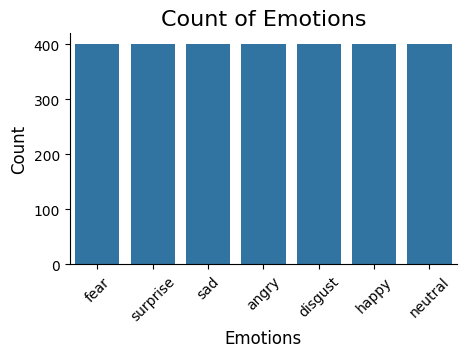

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 3))
plt.title('Count of Emotions', size=16)
sns.barplot(x=df.Emotions.value_counts().index, y=df.Emotions.value_counts())
plt.xlabel('Emotions', size=12)
plt.ylabel('Count', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.xticks(rotation=45)  # Rotasi label x untuk lebih mudah dibaca
plt.show()

- Waveplots - Waveplots memberi tahu kami kenyaringan audio pada waktu tertentu.
- Spektogram - Spektogram adalah representasi visual dari spektrum frekuensi suara atau sinyal lain yang bervariasi terhadap waktu. Ini adalah representasi frekuensi yang berubah terhadap waktu untuk sinyal audio/musik tertentu.

In [49]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

In [46]:
labels = df["Emotions"].unique().tolist()

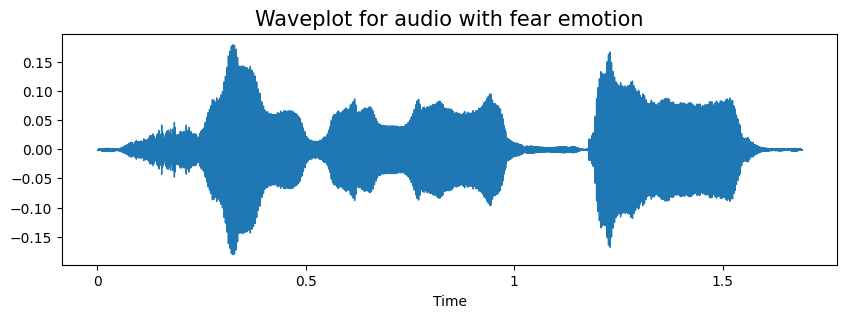

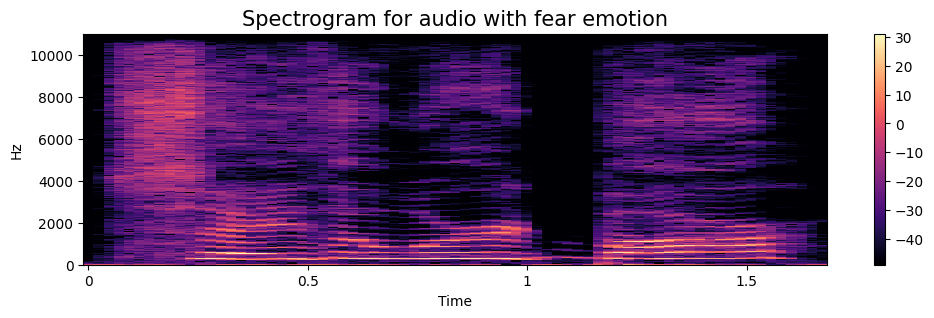

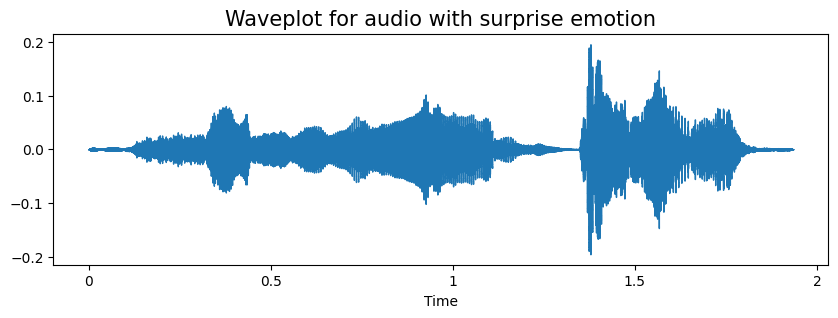

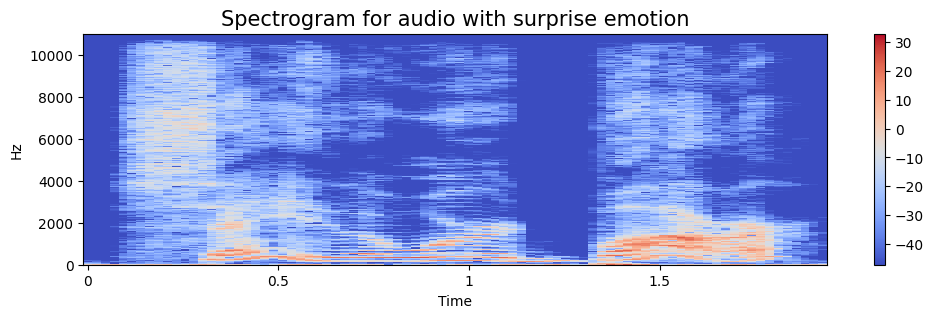

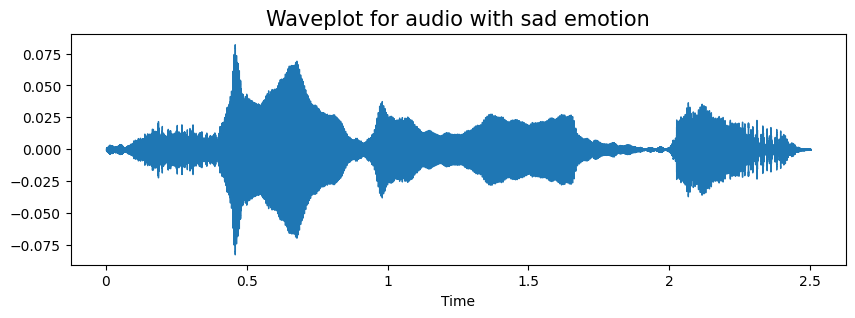

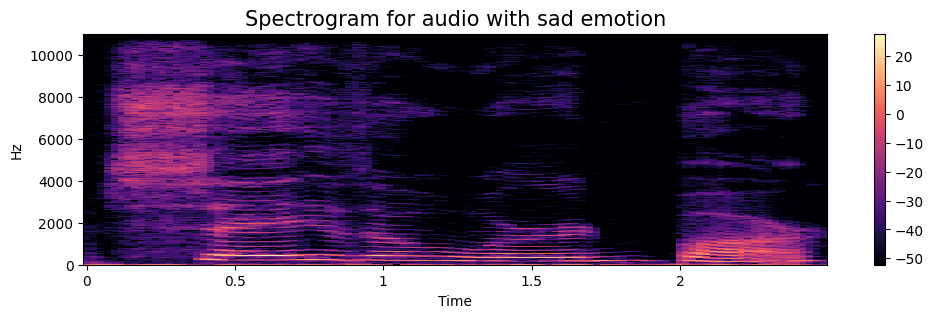

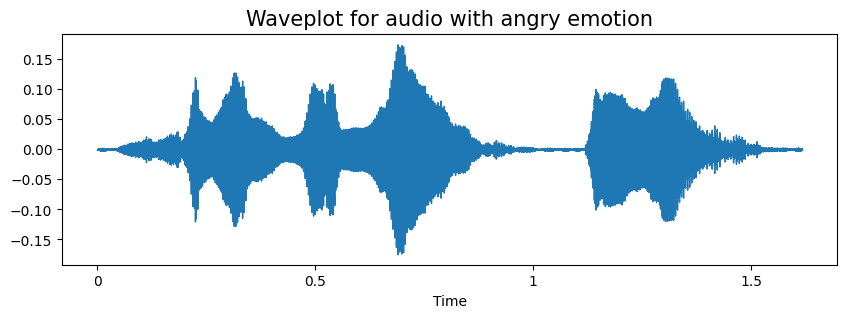

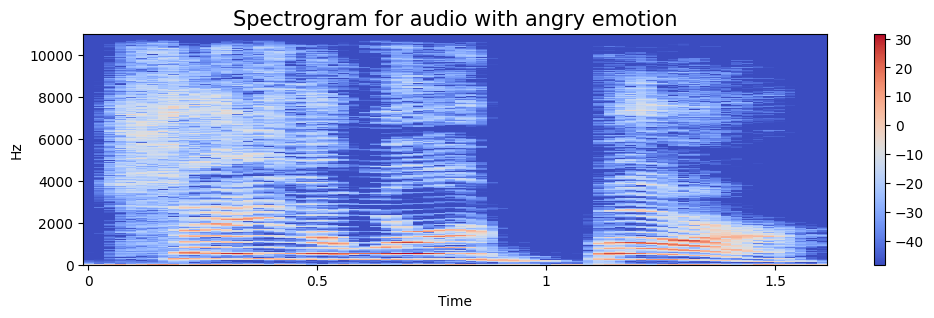

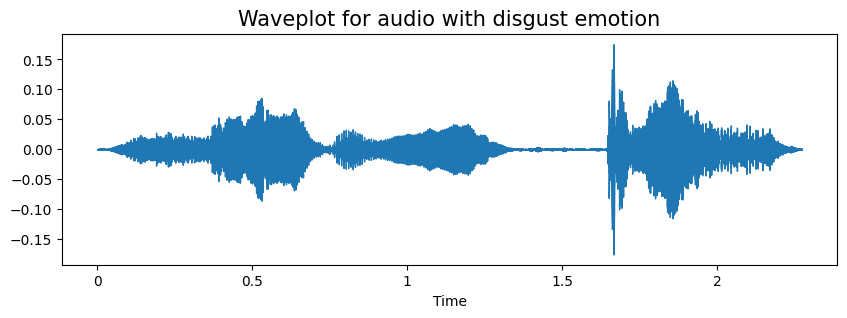

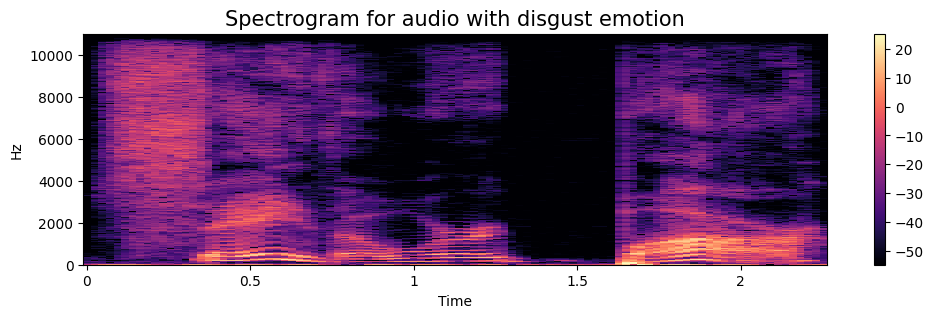

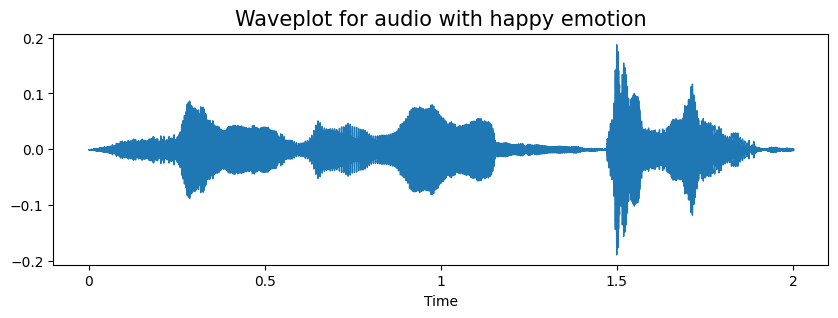

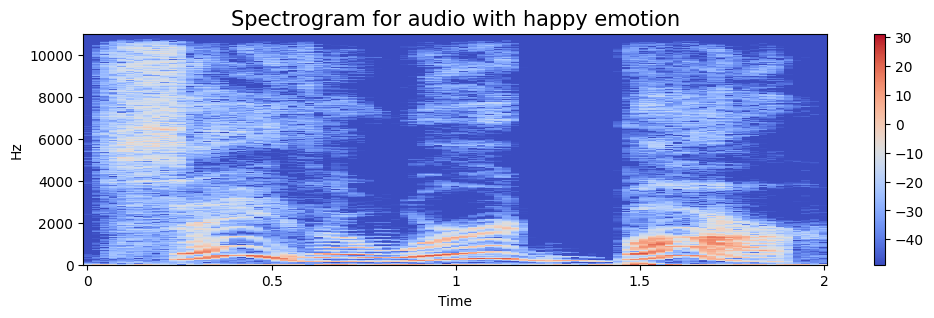

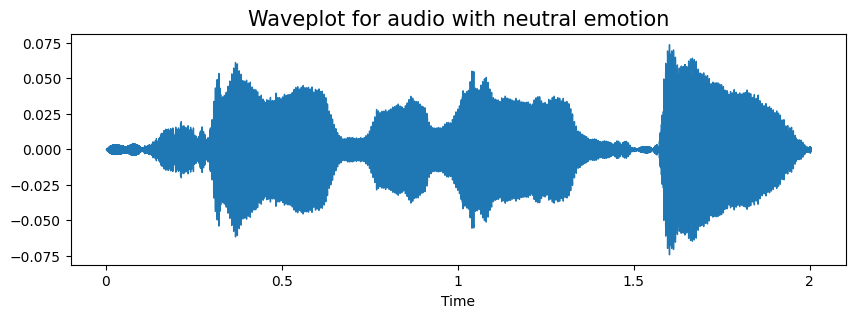

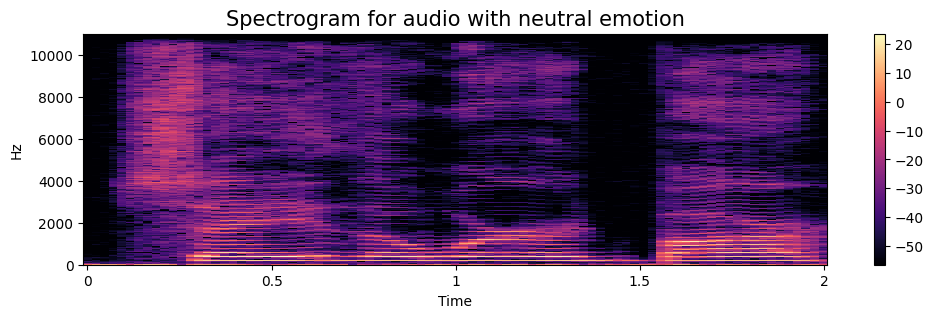

In [54]:
for label in labels:
  emotion = label
  path = np.array(df.Path[df.Emotions == emotion])[1]
  data, sampling_rate = librosa.load(path)
  create_waveplot(data, sampling_rate, emotion)
  create_spectrogram(data, sampling_rate, emotion)
  display(ipd.Audio(path))

# Data Augmentation

- Augmentasi data adalah proses di mana membuat sampel data sintetik baru dengan menambahkan gangguan kecil pada set pelatihan awal.
- Untuk menghasilkan data sintaksis untuk audio, kita dapat **apply noise injection, shifting time, changing pitch and speed.**
- Tujuannya adalah membuat model invarian terhadap gangguan tersebut dan meningkatkan kemampuannya untuk melakukan generalisasi.
- Agar ini berfungsi, penambahan gangguan harus mempertahankan label yang sama dengan sampel pelatihan asli.
Pada gambar, augmentasi data dapat dilakukan dengan menggeser gambar, memperbesar, memutar ...

In [136]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, Rate=0.2):
    return librosa.effects.time_stretch(data, rate = Rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*10000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate = 22050, pitch_factor=0.7): # sampling rate diberi manual, jadi run dlu yang bawahnya ini
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)

In [137]:
# taking any example and checking for techniques.
path = np.array(df.Path)[1]
data, sample_rate = librosa.load(path)

In [139]:
# Definisikan teknik augmentasi yang akan digunakan
augmentation_techniques = [noise, stretch, shift, pitch]

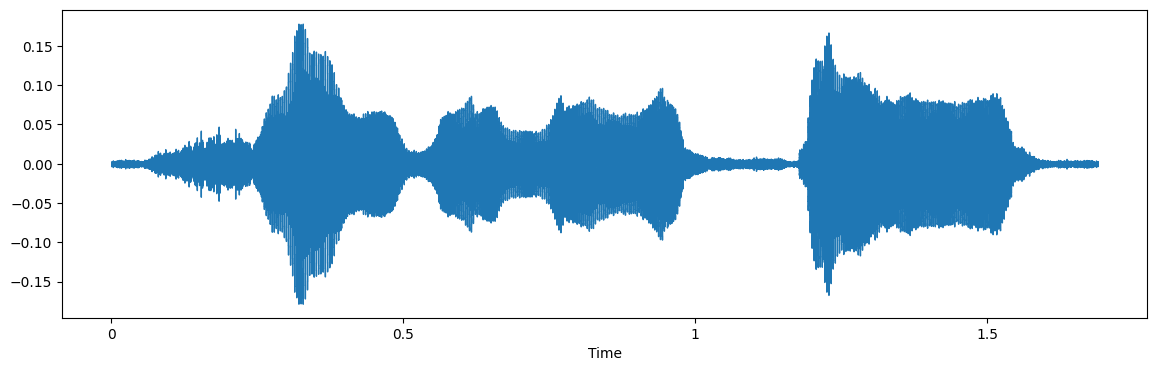

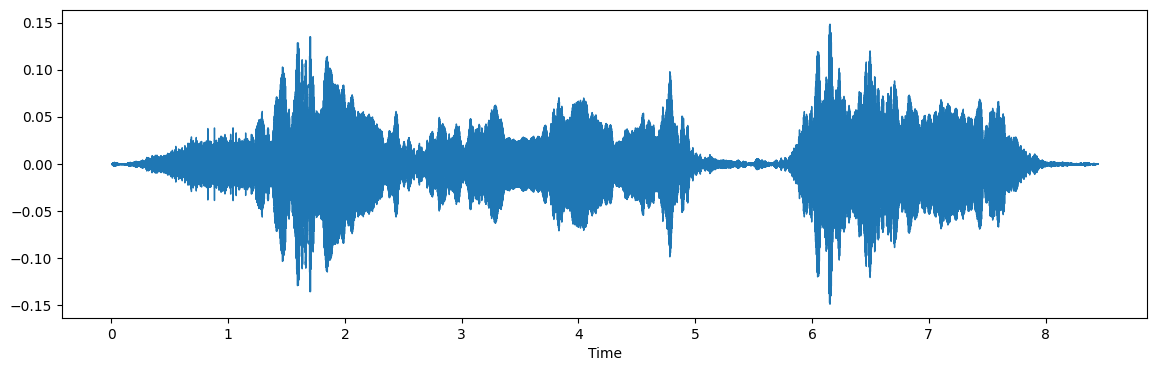

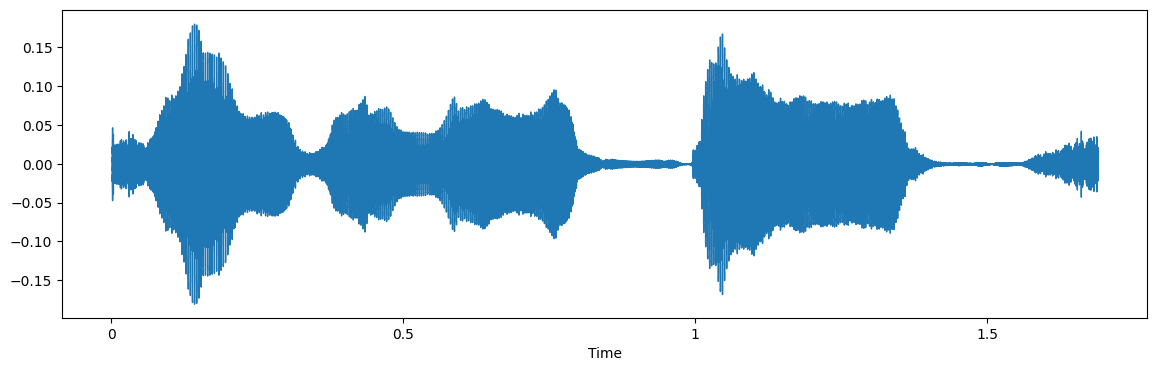

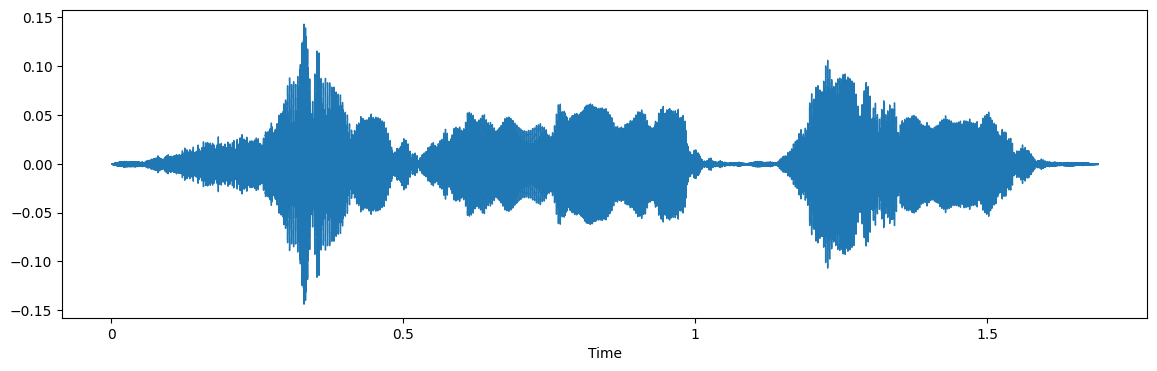

In [140]:
# Loop untuk menerapkan setiap teknik augmentasi
for technique in augmentation_techniques:
  augmented_data = technique(data)

  plt.figure(figsize=(14,4))
  librosa.display.waveshow(y=augmented_data, sr=sample_rate)
  display(Audio(augmented_data, rate=sample_rate))

# Feature Extraction

# Feature Extraction from Audio Signals

In audio signal processing, valuable features can be extracted from the sample rate and sample data, allowing for various transformations. Some of the key features that can be extracted include:

- **Zero Crossing Rate**: The rate of sign-changes of the signal during the duration of a particular frame.
- **Energy**: The sum of squares of the signal values, normalized by the respective frame length.
- **Entropy of Energy**: The entropy of sub-frames’ normalized energies. It can be interpreted as a measure of abrupt changes.
- **Spectral Centroid**: The center of gravity of the spectrum.
- **Spectral Spread**: The second central moment of the spectrum.
- **Spectral Entropy**: Entropy of the normalized spectral energies for a set of sub-frames.
- **Spectral Flux**: The squared difference between the normalized magnitudes of the spectra of the two successive frames.
- **Spectral Rolloff**: The frequency below which 90% of the magnitude distribution of the spectrum is concentrated.
- **MFCCs (Mel Frequency Cepstral Coefficients)**: Form a cepstral representation where the frequency bands are not linear but distributed according to the mel-scale.
- **Chroma Vector**: A 12-element representation of the spectral energy where the bins represent the 12 equal-tempered pitch classes of Western-type music (semitone spacing).
- **Chroma Deviation**: The standard deviation of the 12 chroma coefficients.

These features provide valuable insights into the characteristics and properties of audio signals, which can be utilized for various applications in audio processing and analysis.

Dalam proyek ini saya tidak mendalami proses pemilihan fitur untuk memeriksa fitur mana yang bagus untuk kumpulan data kami, melainkan saya hanya mengekstrak 5 fitur:

- Zero Crossing Rate
- Chroma_stft
- MFCC
- RMS(root mean square) value
- MelSpectogram

In [141]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally

    return result

In [142]:
def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)

    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)

    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically

    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically

    return result

In [143]:
X, Y = [], []
for path, emotion in zip(df.Path, df.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

In [144]:
len(X), len(Y), df.Path.shape

(8400, 8400, (2800,))

In [145]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

0         1         2         3         4         5         6  \
0  0.043198  0.366880  0.447448  0.653717  0.598985  0.415585  0.370681   
1  0.215322  0.544898  0.694327  0.825390  0.672283  0.564511  0.473116   
2  0.049556  0.396335  0.341708  0.493934  0.673286  0.501197  0.359528   
3  0.043208  0.209282  0.368017  0.678081  0.617304  0.335684  0.250542   
4  0.131919  0.431442  0.743116  0.767364  0.473635  0.330958  0.276009   

          7         8         9  ...       153       154       155       156  \
0  0.330806  0.289218  0.368666  ...  0.000093  0.000102  0.000093  0.000101   
1  0.432815  0.457961  0.562127  ...  0.001839  0.001863  0.001972  0.001970   
2  0.343806  0.305200  0.273869  ...  0.000022  0.000021  0.000028  0.000025   
3  0.209602  0.147268  0.181896  ...  0.000125  0.000064  0.000065  0.000070   
4  0.279048  0.291368  0.423326  ...  0.000560  0.000500  0.000533  0.000524   

        157       158       159       160           161  labels  
0  0.000091  0.000044  0.000039  0.000024  2.587468e-06    fear  
1  0.001783  0.001755  0.001749  0.001712  1.662709e-03    fear  
2  0.000023  0.000026  0.000019  0.000006  3.712694e-07    fear  
3  0.000042  0.000019  0.000008  0.000005  7.076098e-07    fear  
4  0.000456  0.000438  0.000446  0.000438  4.536045e-04    fear  

[5 rows x 163 columns]

# Data Preparation

In [146]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [147]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [148]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((6300, 162), (6300, 7), (2100, 162), (2100, 7))

In [149]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((6300, 162), (6300, 7), (2100, 162), (2100, 7))

In [150]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((6300, 162, 1), (6300, 7), (2100, 162, 1), (2100, 7))

# Modeling

In [155]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=7, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, 162, 256)          1536      
                                                                 
 max_pooling1d_8 (MaxPoolin  (None, 81, 256)           0         
 g1D)                                                            
                                                                 
 conv1d_9 (Conv1D)           (None, 81, 256)           327936    
                                                                 
 max_pooling1d_9 (MaxPoolin  (None, 41, 256)           0         
 g1D)                                                            
                                                                 
 conv1d_10 (Conv1D)          (None, 41, 128)           163968    
                                                                 
 max_pooling1d_10 (MaxPooli  (None, 21, 128)          

In [156]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=64, epochs=10, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/10
99/99 [==============================] - 64s 580ms/step - loss: 1.4741 - accuracy: 0.4278 - val_loss: 0.7642 - val_accuracy: 0.7862 - lr: 0.0010
Epoch 2/10
99/99 [==============================] - 56s 572ms/step - loss: 0.7499 - accuracy: 0.7400 - val_loss: 0.4195 - val_accuracy: 0.8538 - lr: 0.0010
Epoch 3/10
99/99 [==============================] - 48s 481ms/step - loss: 0.4848 - accuracy: 0.8308 - val_loss: 0.2213 - val_accuracy: 0.9348 - lr: 0.0010
Epoch 4/10
99/99 [==============================] - 45s 458ms/step - loss: 0.3558 - accuracy: 0.8795 - val_loss: 0.1948 - val_accuracy: 0.9271 - lr: 0.0010
Epoch 5/10
99/99 [==============================] - 40s 402ms/step - loss: 0.2703 - accuracy: 0.9076 - val_loss: 0.1484 - val_accuracy: 0.9481 - lr: 0.0010
Epoch 6/10
99/99 [==============================] - 42s 421ms/step - loss: 0.2183 - accuracy: 0.9275 - val_loss: 0.1230 - val_accuracy: 0.9567 - lr: 0.0010
Epoch 7/10
99/99 [==============================] - 40s 409ms/st

In [157]:
# Simpan model dalam format HDF5
model.save('/content/drive/MyDrive/Colab Notebooks/1. BISA AI - [Studi Independen]/Natural Language Preprocessing/Enroll - Feature Extraction Speech/emotional-speech-dataset/Speech_Emotional_Recognition.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [158]:
from tensorflow.keras.models import load_model

# Muat model dari file HDF5
model = load_model('/content/drive/MyDrive/Colab Notebooks/1. BISA AI - [Studi Independen]/Natural Language Preprocessing/Enroll - Feature Extraction Speech/emotional-speech-dataset/Speech_Emotional_Recognition.h5')

66/66 [==============================] - 7s 104ms/step - loss: 0.1069 - accuracy: 0.9686
Accuracy of our model on test data :  96.8571424484253 %


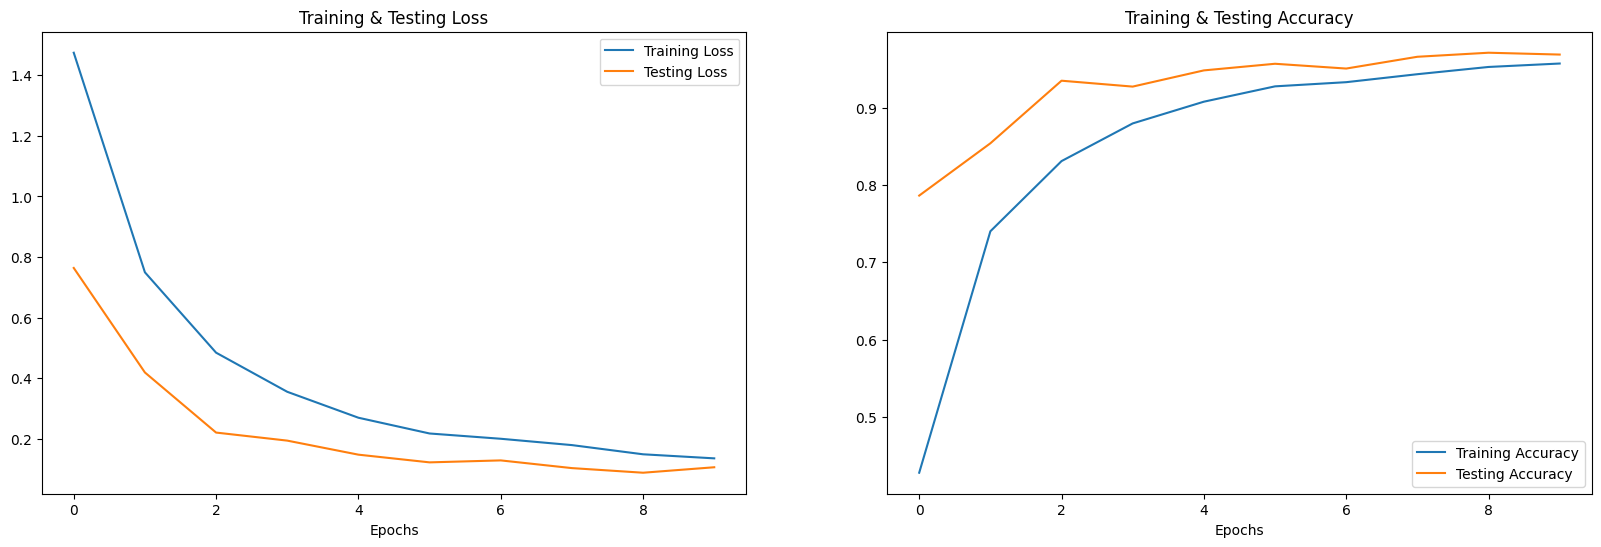

In [160]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(10)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [161]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

66/66 [==============================] - 3s 40ms/step


In [162]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

Predicted Labels Actual Labels
0              sad       disgust
1            happy         happy
2          disgust       disgust
3            angry         angry
4            happy         happy
5             fear          fear
6             fear          fear
7          neutral       neutral
8          disgust       disgust
9             fear          fear

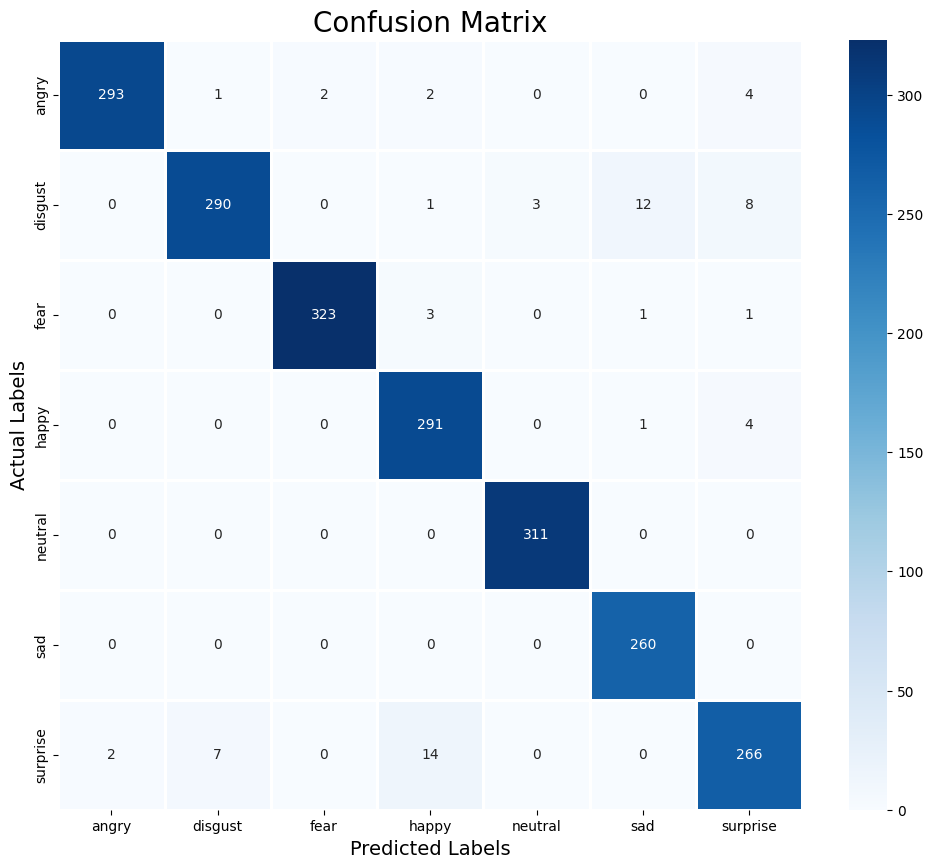

In [163]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [164]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.99      0.97      0.98       302
     disgust       0.97      0.92      0.95       314
        fear       0.99      0.98      0.99       328
       happy       0.94      0.98      0.96       296
     neutral       0.99      1.00      1.00       311
         sad       0.95      1.00      0.97       260
    surprise       0.94      0.92      0.93       289

    accuracy                           0.97      2100
   macro avg       0.97      0.97      0.97      2100
weighted avg       0.97      0.97      0.97      2100



- We can see our model is more accurate in predicting surprise, angry emotions and it makes sense also because audio files of these emotions differ to other audio files in a lot of ways like pitch, speed etc..
- We overall achieved 61% accuracy on our test data and its decent but we can improve it more by applying more augmentation techniques and using other feature extraction methods.